# GEOS 505: Problem Set 3

### Background:

As part of your thesis, you are using a physics-based model to predict how the timing and amount of snow water storage in the Boise River Basin will change under alternative future scenarios of climate. You have your model up and running and presented preliminary results for the first time at a recent committee meeting. One of your committee members works with the Idaho NRCS snow survey and points out that your results would be more impactful if you could present them in the context of historical observations of snow water equivalent (SWE). In particular, your committee wants you to plot your simulations on top of historical SNOTEL climatology, presented as follows: 

<img src="../img/trinity_mtn-id-wteq-por.png" alt="Trinity Mtn. SNOTEL" width="1000" style="display: block; margin: 0 auto"/>

This figure, which can be generated on the NRCS website for any SNOTEL site and many water supply basins. This particular image is the 30 year "normals" for the 1991-2020 timeframe at Trinity Mountain SNOTEL site in the Upper Boise. The plot contains a water-year oriented plot of the following items:

- The median SWE vs time,
- The median maximum annual SWE on April 1, 
- The minimum SWE vs time,
- The maximum SWE vs time, and
- Filled in ranges for SWE quintiles (bottom 20%, 20-40%, 40-60%, 60-80%, and top 20%) vs time.

### Problem: 

Your hypothetical task for your thesis and the task for this problem set is to reproduce the above figure in a way that would allow you to analyze and plot historical data at a variety of SNOTEL sites, and in a way that would allow you to plot the corresponding version of this plot with simulated data for a future climate. As such, the expected outcome of this notebook is code that produces an image that looks similar to the above. You may certainly use an alternative color scheme, but make sure that the elements of the plot are labeled.

The outline of the steps is provided below, along with some helpful suggestions of `numpy` and `matplotlib` functions that you will likely need.

### 1. Imports and Definitions

In [60]:
from datetime import datetime, date, timedelta
from dataretrieval import nwis
from metloom.pointdata import SnotelPointData
from metloom.variables import SnotelVariables

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

startDate = '1985-10-01'
endDate = '2025-09-30'

startDate_dt = datetime.strptime(startDate, '%Y-%m-%d')
endDate_dt = datetime.strptime(endDate, '%Y-%m-%d')

# Metloom Variables
snotel_stn = '830:ID:SNTL' # Trinity Mountain Snotel Station
snotel_pnt = SnotelPointData(station_id=snotel_stn, name='TrinityMtn')

variables = [snotel_pnt.ALLOWED_VARIABLES.SWE]

### 2. Load the Data and Verify

In [30]:
df_snotel = snotel_pnt.get_daily_data(startDate_dt, endDate_dt, variables)
df_snotel


,,geometry,SWE,SWE_units,datasource
datetime,site,,,,
1985-10-01 08:00:00+00:00,830:ID:SNTL,POINT Z (-115.43818 43.62903 7790),0.0,in,NRCS
1985-10-02 08:00:00+00:00,830:ID:SNTL,POINT Z (-115.43818 43.62903 7790),0.0,in,NRCS
1985-10-03 08:00:00+00:00,830:ID:SNTL,POINT Z (-115.43818 43.62903 7790),0.0,in,NRCS
1985-10-04 08:00:00+00:00,830:ID:SNTL,POINT Z (-115.43818 43.62903 7790),0.0,in,NRCS
1985-10-05 08:00:00+00:00,830:ID:SNTL,POINT Z (-115.43818 43.62903 7790),0.0,in,NRCS
...,...,...,...,...,...
2025-09-26 08:00:00+00:00,830:ID:SNTL,POINT Z (-115.43818 43.62903 7790),0.0,in,NRCS
2025-09-27 08:00:00+00:00,830:ID:SNTL,POINT Z (-115.43818 43.62903 7790),0.0,in,NRCS
2025-09-28 08:00:00+00:00,830:ID:SNTL,POINT Z (-115.43818 43.62903 7790),0.0,in,NRCS


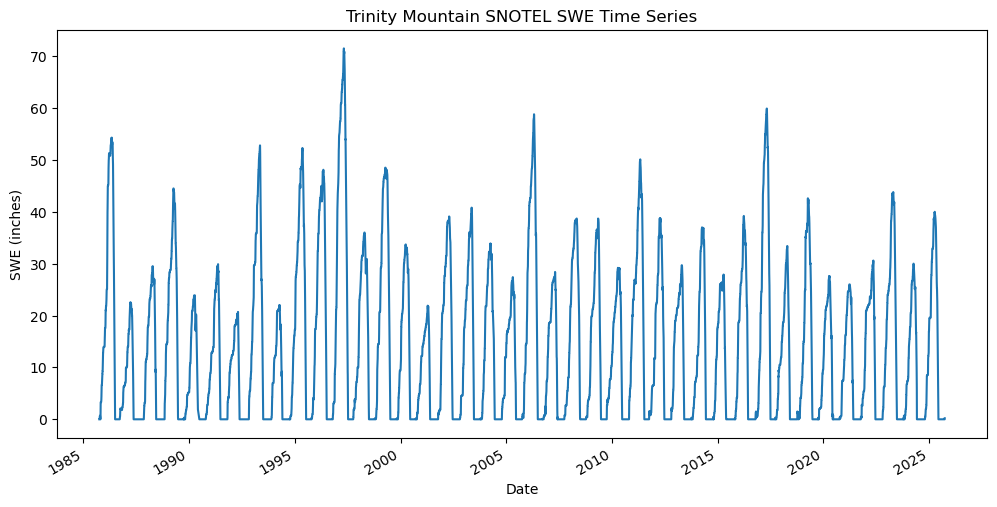

In [31]:
df_snotel.reset_index(level='site', inplace=True)
df_snotel['SWE'].plot(title='Trinity Mountain SNOTEL SWE Time Series', ylabel='SWE (inches)', xlabel='Date', figsize=(12,6))
plt.show()

In [32]:
nYears = (endDate_dt.year - startDate_dt.year) + 1
nYears

41

### 3. Prep Data and Preallocate Storage

In [61]:
swe_time_series = np.zeros((nYears, 365))

#SWE time series matrix (water-year)
#water-year function
def water_year(date):
    return date.year if date.month >= 10 else date.year - 1

#Years range (based on date range)
wy_start = startDate_dt.year
wy_end = endDate_dt.year
wy_years = np.arange(wy_start, wy_end+1)
n_wy = len(wy_years)
swe_matrix = np.full((n_wy, 365), np.nan)  #fill with NaNs to allow missing days

#Date to a water-year day (0-364)---> matrix
for dt, row in df_snotel.iterrows():
    d = dt.date()
    wy = water_year(d)
    if wy < wy_start or wy > wy_end:
        continue
    day_index = (d - date(wy, 10, 1)).days
    #skip Feb 29
    if 0 <= day_index < 365:
        wy_idx = wy - wy_start
        swe_matrix[wy_idx, day_index] = row['SWE']

# Convert to pandas DataFrame
wy_dates = [ (datetime(wy, 10, 1) + timedelta(days=i)).strftime('%b %d') for i in range(365) ]
swe_df = pd.DataFrame(swe_matrix, index=wy_years, columns=np.arange(1,366))
print('swe_df shape', swe_df.shape)
print(swe_df.iloc[0,:10])

swe_df shape (41, 365)
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.2
8     0.6
9     0.6
10    0.6
Name: 1985, dtype: float64


### 4. Analyze Data

In [66]:
#Percentiles (0,20,40,60,80,100)
pctl_edges = [0, 20, 40, 60, 80, 100]
quintiles = np.nanpercentile(swe_df.values, pctl_edges, axis=0)
median = np.nanpercentile(swe_df.values, 50, axis=0)
min_swe = np.nanmin(swe_df.values, axis=0)
max_swe = np.nanmax(swe_df.values, axis=0)

# Median SWE on April 1
wy_day_apr1 = (datetime(2000,4,1) - datetime(1999,10,1)).days
apr1_vals = swe_df.iloc[:, wy_day_apr1]
median_apr1 = np.nanmedian(apr1_vals)
min_apr1 = np.nanmin(apr1_vals)
max_apr1 = np.nanmax(apr1_vals)
print(f'The median SWE on Apr 1 is {median_apr1} in.')

The median SWE on Apr 1 is 34.8 in.


### 5. Create Plot

Note: Here is a link to a list of named colors in matplotlib: https://matplotlib.org/stable/gallery/color/named_colors.html. 

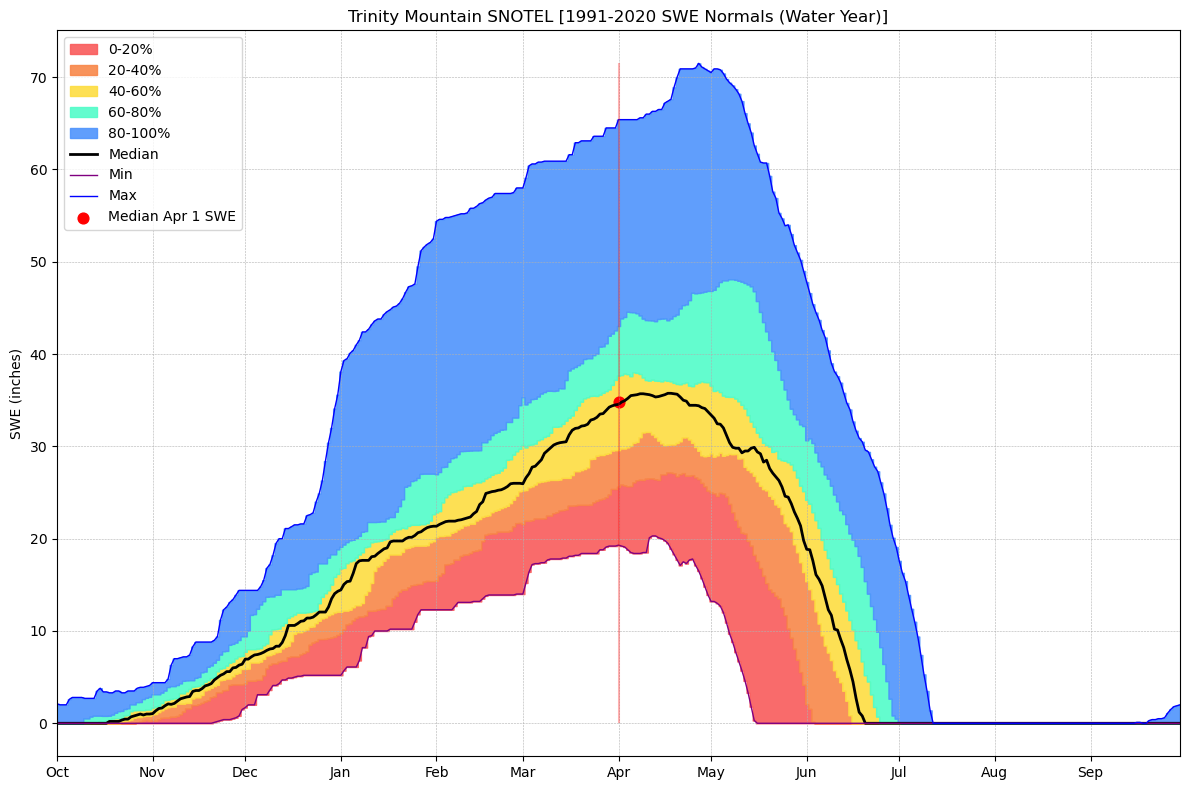

In [68]:
# x-axis labels
days = np.arange(1, 366)
x_dates = [datetime(2000,10,1) + timedelta(days=int(d-1)) for d in days]
month_locator = mdates.MonthLocator(bymonth=[10,11,12,1,2,3,4,5,6,7,8,9])
months_fmt = mdates.DateFormatter('%b')

fig, ax = plt.subplots(figsize=(12,8))

# Quintile bands
colors = ["#f95b5b", "#f88749", "#fddd41", "#52fcc9", "#4f94fc"]
for i in range(len(pctl_edges)-1):
    low = quintiles[i,:]
    high = quintiles[i+1,:]
    ax.fill_between(x_dates, low, high, color=colors[i], step='mid', alpha=0.9, label=f'{pctl_edges[i]}-{pctl_edges[i+1]}%')

# Plot median line
ax.plot(x_dates, median, color='black', linewidth=2, label='Median')

# Plot min and max lines
ax.plot(x_dates, min_swe, color='purple', linewidth=1, label='Min')
ax.plot(x_dates, max_swe, color='blue', linewidth=1, label='Max')

# Plot median maximum SWE on April 1.
ax.scatter([datetime(2001,4,1)], [median_apr1], color='red', s=60, label='Median Apr 1 SWE')
ax.vlines(datetime(2001,4,1), ymin=min_swe.min(), ymax=max_swe.max(), color='red', alpha=0.3)

ax.set_title('Trinity Mountain SNOTEL [1991-2020 SWE Normals (Water Year)]')
ax.set_ylabel('SWE (inches)')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(months_fmt)
ax.set_xlim([datetime(2000,10,1), datetime(2001,9,30)])
ax.grid(linestyle='--',linewidth=0.4)
ax.legend(loc='upper left', fontsize=10)
plt.tight_layout()
plt.savefig('trinity_snotel_climatology.png', dpi=300)
plt.show()